In [1]:
import EOSutils as meos

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.style.use('classic')

from astropy.table import Table
from astropy import units as u
from astropy.constants import G

import mesa_helper as mh
import os
import shutil
import copy

from scipy import interpolate, optimize
from scipy.linalg import lstsq as scipy_lstsq
from scipy.ndimage import gaussian_filter
import scipy.integrate as integrate
import decimal 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
def read_CMSlike(filename,X,Y):
    """
    read in a data table in CMS-like format, where columns are
    log10T[K] log10P[erg/cm3] log10rho[g/cm3] log10E[erg/g] log10S[erg/g/K]
    """
    data = np.genfromtxt(filename)
    EOStable = meos.simple_table()

    EOStable.X = X
    EOStable.Y = Y
    EOStable.Z = 1.0 - X - Y

    EOStable.atomic_number = EOStable.X + 2*(1.-EOStable.X)
    EOStable.mass_number = EOStable.X + 4*(1.-EOStable.X)

    EOStable.independent_arr_1 = np.unique(data[:,0])
    EOStable.independent_arr_2 = np.unique(data[:,2])

    nT = len(EOStable.independent_arr_1)
    nrho = len(EOStable.independent_arr_2)

    EOStable.independent_var_1 = 'T'
    EOStable.independent_var_2 = 'rho'

    EOStable.log10Tgrid, EOStable.log10rhogrid = np.meshgrid(EOStable.independent_arr_1, EOStable.independent_arr_2)
    EOStable.log10Pgrid = np.zeros_like(EOStable.log10Tgrid)
    EOStable.log10Egrid = np.zeros_like(EOStable.log10Tgrid)
    EOStable.log10Sgrid = np.zeros_like(EOStable.log10Tgrid)
    
    for i in range(nT):
        EOStable.log10Pgrid[:,i] = data[:,1][i*nrho : (i+1)*nrho]
        EOStable.log10Egrid[:,i] = data[:,3][i*nrho : (i+1)*nrho]
        EOStable.log10Sgrid[:,i] = data[:,4][i*nrho : (i+1)*nrho]
             
    return EOStable

In [98]:
SCVH_H = meos.SCVHtable("../../1995_SCVH/h_tab_i.dat",units='cgs',F_smoothing_kernel=5)
SCVH_He = meos.SCVHtable("../../1995_SCVH/he_tab_i.dat",units='cgs',F_smoothing_kernel=5)

CMS19_H = meos.CMStable("../../2021_chabrier+_tables/TABLE_H_Trho_v1",units='cgs',F_smoothing_kernel=5)
CMS19_He = meos.CMStable("../../2021_chabrier+_tables/TABLE_HE_Trho_v1",units='cgs',F_smoothing_kernel=5)

tc_H_1 = read_CMSlike(filename='../tc_CMS19_H_smoothing=1.txt',X=1.,Y=0.)
tc_He_1 = read_CMSlike(filename='../tc_CMS19_He_smoothing=1.txt',X=0.,Y=1.)

tc_H_5 = read_CMSlike(filename='../tc_CMS19_H_smoothing=5.txt',X=1.,Y=0.)
tc_He_5 = read_CMSlike(filename='../tc_CMS19_He_smoothing=5.txt',X=0.,Y=1.)

tc_H_10 = read_CMSlike(filename='../tc_CMS19_H_smoothing=10.txt',X=1.,Y=0.)
tc_He_10 = read_CMSlike(filename='../tc_CMS19_He_smoothing=10.txt',X=0.,Y=1.)


# mask arrays
CMS19_H_mask = ~meos.boundary_mask_rhoT(CMS19_H) & ~meos.boundary_mask_PT(CMS19_H)
CMS19_H_rho_toplot = np.ma.array(CMS19_H.log10rhogrid, mask=~CMS19_H_mask, fill_value = np.nan)
CMS19_H_P_toplot = np.ma.array(CMS19_H.log10Pgrid, mask=~CMS19_H_mask, fill_value = np.nan)
CMS19_H_E_toplot = np.ma.array(CMS19_H.log10Egrid, mask=~CMS19_H_mask, fill_value = np.nan)
CMS19_H_S_toplot = np.ma.array(CMS19_H.log10Sgrid, mask=~CMS19_H_mask, fill_value = np.nan)

CMS19_He_mask = ~meos.boundary_mask_rhoT(CMS19_He) & ~meos.boundary_mask_PT(CMS19_He)
CMS19_He_rho_toplot = np.ma.array(CMS19_He.log10rhogrid, mask=~CMS19_He_mask, fill_value = np.nan)
CMS19_He_P_toplot = np.ma.array(CMS19_He.log10Pgrid, mask=~CMS19_He_mask, fill_value = np.nan)
CMS19_He_E_toplot = np.ma.array(CMS19_He.log10Egrid, mask=~CMS19_He_mask, fill_value = np.nan)
CMS19_He_S_toplot = np.ma.array(CMS19_He.log10Sgrid, mask=~CMS19_He_mask, fill_value = np.nan)

tc_H_1_mask = ~meos.boundary_mask_rhoT(tc_H_1) & ~meos.boundary_mask_PT(tc_H_1)
tc_H_1_rho_toplot = np.ma.array(tc_H_1.log10rhogrid, mask=~tc_H_1_mask, fill_value = np.nan)
tc_H_1_P_toplot = np.ma.array(tc_H_1.log10Pgrid, mask=~tc_H_1_mask, fill_value = np.nan)
tc_H_1_E_toplot = np.ma.array(tc_H_1.log10Egrid, mask=~tc_H_1_mask, fill_value = np.nan)
tc_H_1_S_toplot = np.ma.array(tc_H_1.log10Sgrid, mask=~tc_H_1_mask, fill_value = np.nan)

tc_He_1_mask = ~meos.boundary_mask_rhoT(tc_He_1) & ~meos.boundary_mask_PT(tc_He_1)
tc_He_1_rho_toplot = np.ma.array(tc_He_1.log10rhogrid, mask=~tc_He_1_mask, fill_value = np.nan)
tc_He_1_P_toplot = np.ma.array(tc_He_1.log10Pgrid, mask=~tc_He_1_mask, fill_value = np.nan)
tc_He_1_E_toplot = np.ma.array(tc_He_1.log10Egrid, mask=~tc_He_1_mask, fill_value = np.nan)
tc_He_1_S_toplot = np.ma.array(tc_He_1.log10Sgrid, mask=~tc_He_1_mask, fill_value = np.nan)

tc_H_5_mask = ~meos.boundary_mask_rhoT(tc_H_5) & ~meos.boundary_mask_PT(tc_H_5)
tc_H_5_rho_toplot = np.ma.array(tc_H_5.log10rhogrid, mask=~tc_H_5_mask, fill_value = np.nan)
tc_H_5_P_toplot = np.ma.array(tc_H_5.log10Pgrid, mask=~tc_H_5_mask, fill_value = np.nan)
tc_H_5_E_toplot = np.ma.array(tc_H_5.log10Egrid, mask=~tc_H_5_mask, fill_value = np.nan)
tc_H_5_S_toplot = np.ma.array(tc_H_5.log10Sgrid, mask=~tc_H_5_mask, fill_value = np.nan)

tc_He_5_mask = ~meos.boundary_mask_rhoT(tc_He_5) & ~meos.boundary_mask_PT(tc_He_5)
tc_He_5_rho_toplot = np.ma.array(tc_He_5.log10rhogrid, mask=~tc_He_5_mask, fill_value = np.nan)
tc_He_5_P_toplot = np.ma.array(tc_He_5.log10Pgrid, mask=~tc_He_5_mask, fill_value = np.nan)
tc_He_5_E_toplot = np.ma.array(tc_He_5.log10Egrid, mask=~tc_He_5_mask, fill_value = np.nan)
tc_He_5_S_toplot = np.ma.array(tc_He_5.log10Sgrid, mask=~tc_He_5_mask, fill_value = np.nan)

tc_H_10_mask = ~meos.boundary_mask_rhoT(tc_H_10) & ~meos.boundary_mask_PT(tc_H_10)
tc_H_10_rho_toplot = np.ma.array(tc_H_10.log10rhogrid, mask=~tc_H_10_mask, fill_value = np.nan)
tc_H_10_P_toplot = np.ma.array(tc_H_10.log10Pgrid, mask=~tc_H_10_mask, fill_value = np.nan)
tc_H_10_E_toplot = np.ma.array(tc_H_10.log10Egrid, mask=~tc_H_10_mask, fill_value = np.nan)
tc_H_10_S_toplot = np.ma.array(tc_H_10.log10Sgrid, mask=~tc_H_10_mask, fill_value = np.nan)

tc_He_10_mask = ~meos.boundary_mask_rhoT(tc_He_10) & ~meos.boundary_mask_PT(tc_He_10)
tc_He_10_rho_toplot = np.ma.array(tc_He_10.log10rhogrid, mask=~tc_He_10_mask, fill_value = np.nan)
tc_He_10_P_toplot = np.ma.array(tc_He_10.log10Pgrid, mask=~tc_He_10_mask, fill_value = np.nan)
tc_He_10_E_toplot = np.ma.array(tc_He_10.log10Egrid, mask=~tc_He_10_mask, fill_value = np.nan)
tc_He_10_S_toplot = np.ma.array(tc_He_10.log10Sgrid, mask=~tc_He_10_mask, fill_value = np.nan)


In [119]:
print(SCVH_H.independent_arr_1)

[2.1  2.18 2.26 2.34 2.42 2.5  2.58 2.66 2.74 2.82 2.9  2.98 3.06 3.14
 3.22 3.3  3.38 3.46 3.54 3.62 3.7  3.78 3.86 3.94 4.02 4.1  4.18 4.26
 4.34 4.42 4.5  4.58 4.66 4.74 4.82 4.9  4.98 5.06 5.14 5.22 5.3  5.38
 5.46 5.54 5.62 5.7  5.78 5.86 5.94 6.02 6.1  6.18 6.26 6.34 6.42 6.5
 6.58 6.66 6.74 6.82 6.9  6.98 7.06]


# change SCVH coords from (P, T) to (rho, T)

In [134]:
SCVH_H_ = meos.simple_table()
SCVH_H_.X = 1.
SCVH_H_.Y = 0.
SCVH_H_.atomic_number = SCVH_H_.X + 2*(1.-SCVH_H_.X)
SCVH_H_.mass_number = SCVH_H_.X + 4*(1.-SCVH_H_.X)


start_Tgrid = SCVH_H.log10Tgrid
start_Pgrid = SCVH_H.log10Pgrid
start_rhogrid = SCVH_H.log10rhogrid
start_Sgrid = SCVH_H.log10Sgrid
start_Ugrid = SCVH_H.log10Egrid

start_Tarr = SCVH_H.independent_arr_1
start_Parr = SCVH_H.independent_arr_2

# re-interpolate to (rho, T) for plot comparison
desired_Tarr = start_Tarr
desired_rhoarr = np.arange(-8.0,3.5,0.05)
SCVH_H_.log10Tgrid, SCVH_H_.log10rhogrid = np.meshgrid(desired_Tarr, desired_rhoarr)
SCVH_H_.log10Pgrid = None
SCVH_H_.log10Sgrid = None
SCVH_H_.log10Egrid = None

# construct an interpolator to get rho as a function of (P, T)
interp_log10rho_given_log10P_log10T_linear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_rhogrid, bounds_error=False, fill_value=None, method='linear')

def interp_log10rho(log10P, log10T):
    return interp_log10rho_given_log10P_log10T_linear((log10P,log10T))
           
def log10rho_abs_diff(log10P, log10rho, log10T):
    return np.abs(log10rho - interp_log10rho(log10P,log10T))


# construct interpolators to get S and U as functions of (P,T)
interp_log10S_given_log10P_log10T_linear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_Sgrid, bounds_error=False, fill_value=None, method='linear')
interp_log10U_given_log10P_log10T_linear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_Ugrid, bounds_error=False, fill_value=None, method='linear')


def reinterp_log10S(log10P, log10T, method='cubic'):
    return interp_log10S_given_log10P_log10T_linear((log10P,log10T))
            
def reinterp_log10U(log10P, log10T, method='cubic'):
    return interp_log10U_given_log10P_log10T_linear((log10P,log10T))

def solve_log10PSU(log10rho, log10T, log10P0=5.):
    opt = optimize.minimize(log10rho_abs_diff, x0=log10P0, args=(log10rho,log10T),bounds=[(1.0,24.0)], tol=1.e-10) 
    opt_log10P = opt.x[0]
        
    recorresponding_log10S = reinterp_log10S(opt_log10P, log10T)
    recorresponding_log10U = reinterp_log10U(opt_log10P, log10T)
    return opt_log10P, recorresponding_log10S, recorresponding_log10U


# interpolate!
log10Pgrid_reinterpolated = np.zeros_like(SCVH_H_.log10Tgrid)
log10Sgrid_reinterpolated = np.zeros_like(SCVH_H_.log10Tgrid)
log10Ugrid_reinterpolated = np.zeros_like(SCVH_H_.log10Tgrid)
        
for i in range(np.shape(SCVH_H_.log10Tgrid)[1]):
    this_log10T = SCVH_H_.log10Tgrid[0][i]
    for j in range(np.shape(SCVH_H_.log10rhogrid)[0]):
        this_log10rho = SCVH_H_.log10rhogrid[:,0][j]

        reinterpolated_log10P, reinterpolated_log10S, reinterpolated_log10U  = solve_log10PSU(log10rho=this_log10rho, log10T=this_log10T, log10P0=CMS19_H.log10Pgrid[j,i])
            
        log10Pgrid_reinterpolated[j,i] = reinterpolated_log10P
        log10Sgrid_reinterpolated[j,i] = reinterpolated_log10S
        log10Ugrid_reinterpolated[j,i] = reinterpolated_log10U

SCVH_H_.log10Pgrid = log10Pgrid_reinterpolated
SCVH_H_.log10Sgrid = log10Sgrid_reinterpolated
SCVH_H_.log10Egrid = log10Ugrid_reinterpolated


# mask arrays
SCVH_H_mask = ~meos.boundary_mask_rhoT(SCVH_H_) & ~meos.boundary_mask_PT(SCVH_H_)
SCVH_H_rho_toplot = np.ma.array(SCVH_H_.log10rhogrid, mask=~SCVH_H_mask, fill_value = np.nan)
SCVH_H_P_toplot = np.ma.array(SCVH_H_.log10Pgrid, mask=~SCVH_H_mask, fill_value = np.nan)
SCVH_H_E_toplot = np.ma.array(SCVH_H_.log10Egrid, mask=~SCVH_H_mask, fill_value = np.nan)
SCVH_H_S_toplot = np.ma.array(SCVH_H_.log10Sgrid, mask=~SCVH_H_mask, fill_value = np.nan)


In [135]:
SCVH_He_ = meos.simple_table()
SCVH_He_.X = 1.
SCVH_He_.Y = 0.
SCVH_He_.atomic_number = SCVH_He_.X + 2*(1.-SCVH_He_.X)
SCVH_He_.mass_number = SCVH_He_.X + 4*(1.-SCVH_He_.X)


start_Tgrid = SCVH_He.log10Tgrid
start_Pgrid = SCVH_He.log10Pgrid
start_rhogrid = SCVH_He.log10rhogrid
start_Sgrid = SCVH_He.log10Sgrid
start_Ugrid = SCVH_He.log10Egrid

start_Tarr = SCVH_He.independent_arr_1
start_Parr = SCVH_He.independent_arr_2

# re-interpolate to (rho, T) for plot comparison
desired_Tarr = start_Tarr
desired_rhoarr = np.arange(-8.0,3.5,0.05)
SCVH_He_.log10Tgrid, SCVH_He_.log10rhogrid = np.meshgrid(desired_Tarr, desired_rhoarr)
SCVH_He_.log10Pgrid = None
SCVH_He_.log10Sgrid = None
SCVH_He_.log10Egrid = None

# construct an interpolator to get rho as a function of (P, T)
interp_log10rho_given_log10P_log10T_linear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_rhogrid, bounds_error=False, fill_value=None, method='linear')

def interp_log10rho(log10P, log10T):
    return interp_log10rho_given_log10P_log10T_linear((log10P,log10T))
           
def log10rho_abs_diff(log10P, log10rho, log10T):
    return np.abs(log10rho - interp_log10rho(log10P,log10T))


# construct interpolators to get S and U as functions of (P,T)
interp_log10S_given_log10P_log10T_linear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_Sgrid, bounds_error=False, fill_value=None, method='linear')
interp_log10U_given_log10P_log10T_linear = interpolate.RegularGridInterpolator(points=(start_Parr, start_Tarr), values=start_Ugrid, bounds_error=False, fill_value=None, method='linear')


def reinterp_log10S(log10P, log10T, method='cubic'):
    return interp_log10S_given_log10P_log10T_linear((log10P,log10T))
            
def reinterp_log10U(log10P, log10T, method='cubic'):
    return interp_log10U_given_log10P_log10T_linear((log10P,log10T))

def solve_log10PSU(log10rho, log10T, log10P0=5.):
    opt = optimize.minimize(log10rho_abs_diff, x0=log10P0, args=(log10rho,log10T),bounds=[(1.0,24.0)], tol=1.e-10) 
    opt_log10P = opt.x[0]
        
    recorresponding_log10S = reinterp_log10S(opt_log10P, log10T)
    recorresponding_log10U = reinterp_log10U(opt_log10P, log10T)
    return opt_log10P, recorresponding_log10S, recorresponding_log10U


# interpolate!
log10Pgrid_reinterpolated = np.zeros_like(SCVH_He_.log10Tgrid)
log10Sgrid_reinterpolated = np.zeros_like(SCVH_He_.log10Tgrid)
log10Ugrid_reinterpolated = np.zeros_like(SCVH_He_.log10Tgrid)
        
for i in range(np.shape(SCVH_He_.log10Tgrid)[1]):
    this_log10T = SCVH_He_.log10Tgrid[0][i]
    for j in range(np.shape(SCVH_He_.log10rhogrid)[0]):
        this_log10rho = SCVH_He_.log10rhogrid[:,0][j]

        reinterpolated_log10P, reinterpolated_log10S, reinterpolated_log10U  = solve_log10PSU(log10rho=this_log10rho, log10T=this_log10T, log10P0=CMS19_H.log10Pgrid[j,i])
            
        log10Pgrid_reinterpolated[j,i] = reinterpolated_log10P
        log10Sgrid_reinterpolated[j,i] = reinterpolated_log10S
        log10Ugrid_reinterpolated[j,i] = reinterpolated_log10U

SCVH_He_.log10Pgrid = log10Pgrid_reinterpolated
SCVH_He_.log10Sgrid = log10Sgrid_reinterpolated
SCVH_He_.log10Egrid = log10Ugrid_reinterpolated


# mask arrays
SCVH_He_mask = ~meos.boundary_mask_rhoT(SCVH_He_) & ~meos.boundary_mask_PT(SCVH_He_)
SCVH_He_rho_toplot = np.ma.array(SCVH_He_.log10rhogrid, mask=~SCVH_He_mask, fill_value = np.nan)
SCVH_He_P_toplot = np.ma.array(SCVH_He_.log10Pgrid, mask=~SCVH_He_mask, fill_value = np.nan)
SCVH_He_E_toplot = np.ma.array(SCVH_He_.log10Egrid, mask=~SCVH_He_mask, fill_value = np.nan)
SCVH_He_S_toplot = np.ma.array(SCVH_He_.log10Sgrid, mask=~SCVH_He_mask, fill_value = np.nan)


# Plot

In [136]:
scvh_T_idxs = np.array((11,24,36,49,61))
print(SCVH_H.independent_arr_1[scvh_T_idxs])
print(np.round(SCVH_H.independent_arr_1[scvh_T_idxs],1))

cms_T_idxs = np.array((20,40,60,80,100))
print(cms_T_idxs)
print(CMS19_H.independent_arr_1[cms_T_idxs])


[2.98 4.02 4.98 6.02 6.98]
[3. 4. 5. 6. 7.]
[ 20  40  60  80 100]
[3. 4. 5. 6. 7.]


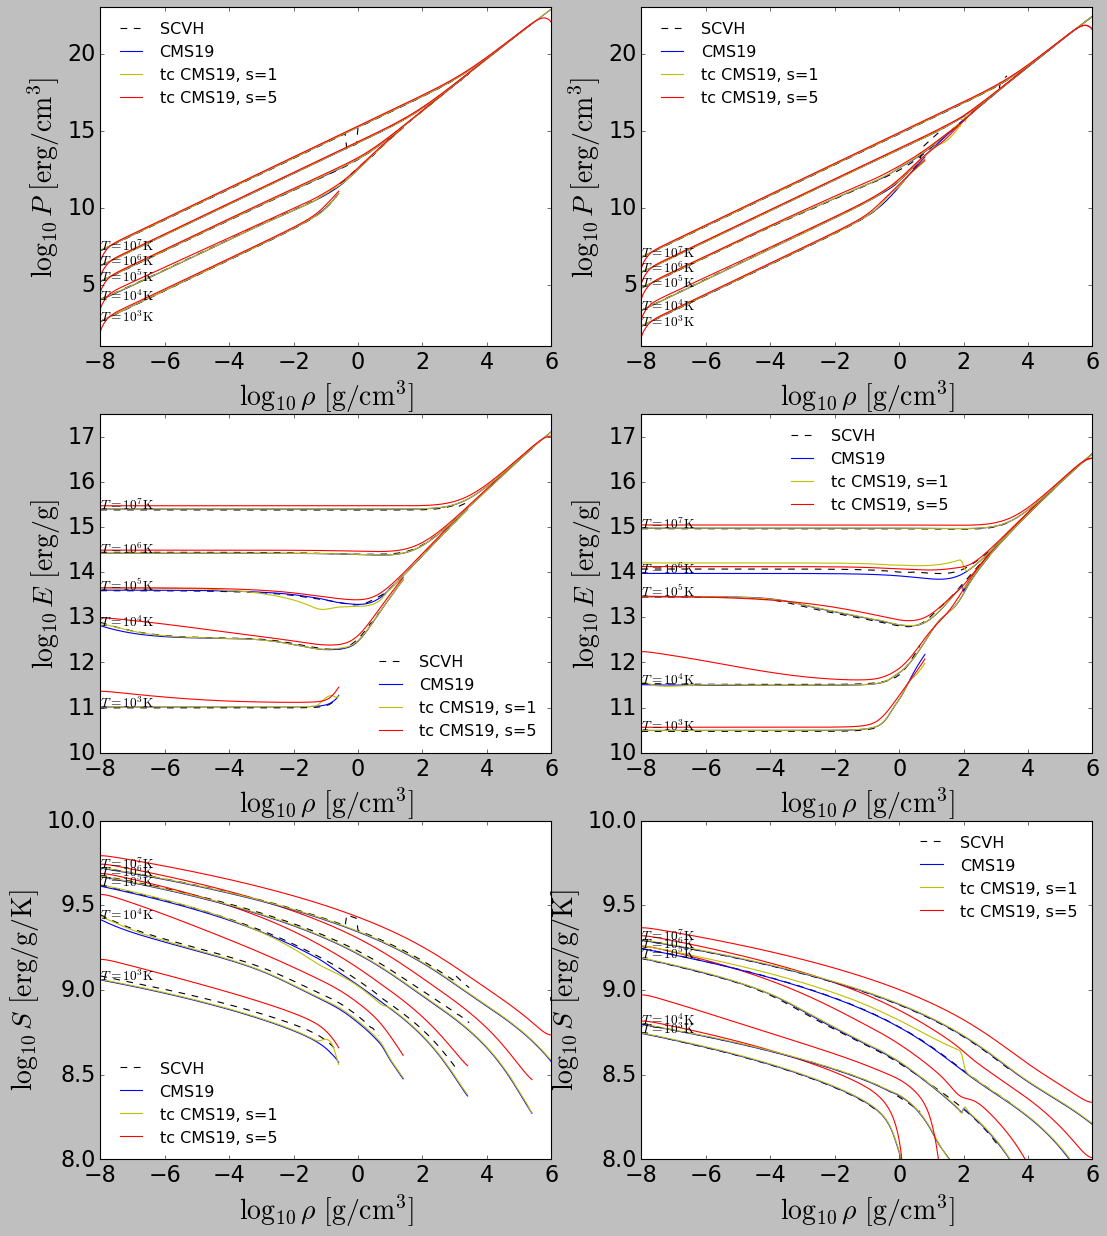

In [138]:
fig, axes = plt.subplots(3,2,figsize=(16,18))

for si in scvh_T_idxs:
    if si==scvh_T_idxs[0]:
        # log10P
        axes[0,0].plot(SCVH_H_rho_toplot[:,si], SCVH_H_P_toplot[:,si], 'k--', label="SCVH")
        axes[0,1].plot(SCVH_He_rho_toplot[:,si], SCVH_He_P_toplot[:,si], 'k--', label="SCVH")

        # log10 E
        axes[1,0].plot(SCVH_H_rho_toplot[:,si], SCVH_H_E_toplot[:,si], 'k--', label="SCVH")
        axes[1,1].plot(SCVH_He_rho_toplot[:,si], SCVH_He_E_toplot[:,si], 'k--', label="SCVH")
        
        # log10S
        axes[2,0].plot(SCVH_H_rho_toplot[:,si], SCVH_H_S_toplot[:,si], 'k--', label="SCVH")
        axes[2,1].plot(SCVH_He_rho_toplot[:,si], SCVH_He_S_toplot[:,si], 'k--', label="SCVH")
        
    else:
        axes[0,0].plot(SCVH_H_rho_toplot[:,si], SCVH_H_P_toplot[:,si], 'k--')
        axes[0,1].plot(SCVH_He_rho_toplot[:,si], SCVH_He_P_toplot[:,si], 'k--')

        # log10 E
        axes[1,0].plot(SCVH_H_rho_toplot[:,si], SCVH_H_E_toplot[:,si], 'k--')
        axes[1,1].plot(SCVH_He_rho_toplot[:,si], SCVH_He_E_toplot[:,si], 'k--')
        
        # log10S
        axes[2,0].plot(SCVH_H_rho_toplot[:,si], SCVH_H_S_toplot[:,si], 'k--')
        axes[2,1].plot(SCVH_He_rho_toplot[:,si], SCVH_He_S_toplot[:,si], 'k--')
        

for ci in cms_T_idxs:
    if ci==cms_T_idxs[0]:
        # log10P
        axes[0,0].plot(CMS19_H_rho_toplot[:,ci], CMS19_H_P_toplot[:,ci], 'b-', label="CMS19")
        axes[0,1].plot(CMS19_He_rho_toplot[:,ci], CMS19_He_P_toplot[:,ci], 'b-', label="CMS19")

        axes[0,0].plot(tc_H_1_rho_toplot[:,ci], tc_H_1_P_toplot[:,ci], 'y-', label="tc CMS19, s=1")
        axes[0,1].plot(tc_He_1_rho_toplot[:,ci], tc_He_1_P_toplot[:,ci], 'y-', label="tc CMS19, s=1")
        
        axes[0,0].plot(tc_H_5_rho_toplot[:,ci], tc_H_5_P_toplot[:,ci], 'r-', label="tc CMS19, s=5")
        axes[0,1].plot(tc_He_5_rho_toplot[:,ci], tc_He_5_P_toplot[:,ci], 'r-', label="tc CMS19, s=5")

        #axes[0,0].plot(tc_H_10_rho_toplot[:,ci], tc_H_10_P_toplot[:,ci], 'm-', label="tc CMS19, s=10")
        #axes[0,1].plot(tc_He_10_rho_toplot[:,ci], tc_He_10_P_toplot[:,ci], 'm-', label="tc CMS19, s=10")

        # log10 E
        axes[1,0].plot(CMS19_H_rho_toplot[:,ci], CMS19_H_E_toplot[:,ci], 'b-', label="CMS19")
        axes[1,1].plot(CMS19_He_rho_toplot[:,ci], CMS19_He_E_toplot[:,ci], 'b-', label="CMS19")
        
        axes[1,0].plot(tc_H_1_rho_toplot[:,ci], tc_H_1_E_toplot[:,ci], 'y-', label="tc CMS19, s=1")
        axes[1,1].plot(tc_He_1_rho_toplot[:,ci], tc_He_1_E_toplot[:,ci], 'y-', label="tc CMS19, s=1")

        axes[1,0].plot(tc_H_5_rho_toplot[:,ci], tc_H_5_E_toplot[:,ci], 'r-', label="tc CMS19, s=5")
        axes[1,1].plot(tc_He_5_rho_toplot[:,ci], tc_He_5_E_toplot[:,ci], 'r-', label="tc CMS19, s=5")

        #axes[1,0].plot(tc_H_10_rho_toplot[:,ci], tc_H_10_E_toplot[:,ci], 'm-', label="tc CMS19, s=10")
        #axes[1,1].plot(tc_He_10_rho_toplot[:,ci], tc_He_10_E_toplot[:,ci], 'm-', label="tc CMS19, s=10")

        # log10S

        axes[2,0].plot(CMS19_H_rho_toplot[:,ci], CMS19_H_S_toplot[:,ci], 'b-', label="CMS19")
        axes[2,1].plot(CMS19_He_rho_toplot[:,ci], CMS19_He_S_toplot[:,ci], 'b-', label="CMS19")

        axes[2,0].plot(tc_H_1_rho_toplot[:,ci], tc_H_1_S_toplot[:,ci], 'y-', label="tc CMS19, s=1")
        axes[2,1].plot(tc_He_1_rho_toplot[:,ci], tc_He_1_S_toplot[:,ci], 'y-', label="tc CMS19, s=1")

        axes[2,0].plot(tc_H_5_rho_toplot[:,ci], tc_H_5_S_toplot[:,ci], 'r-', label="tc CMS19, s=5")
        axes[2,1].plot(tc_He_5_rho_toplot[:,ci], tc_He_5_S_toplot[:,ci], 'r-', label="tc CMS19, s=5")

        #axes[2,0].plot(tc_H_10_rho_toplot[:,ci], tc_H_10_S_toplot[:,ci], 'm-', label="tc CMS19, s=10")
        #axes[2,1].plot(tc_He_10_rho_toplot[:,ci], tc_He_10_S_toplot[:,ci], 'm-', label="tc CMS19, s=10")
        
        
    else:
        # log10P
        axes[0,0].plot(CMS19_H_rho_toplot[:,ci], CMS19_H_P_toplot[:,ci], 'b-')
        axes[0,1].plot(CMS19_He_rho_toplot[:,ci], CMS19_He_P_toplot[:,ci], 'b-')   

        axes[0,0].plot(tc_H_1_rho_toplot[:,ci], tc_H_1_P_toplot[:,ci], 'y-')
        axes[0,1].plot(tc_He_1_rho_toplot[:,ci], tc_He_1_P_toplot[:,ci], 'y-')
        
        axes[0,0].plot(tc_H_5_rho_toplot[:,ci], tc_H_5_P_toplot[:,ci], 'r-')
        axes[0,1].plot(tc_He_5_rho_toplot[:,ci], tc_He_5_P_toplot[:,ci], 'r-')

        #axes[0,0].plot(tc_H_10_rho_toplot[:,ci], tc_H_10_P_toplot[:,ci], 'm-')
        #axes[0,1].plot(tc_He_10_rho_toplot[:,ci], tc_He_10_P_toplot[:,ci], 'm-')
        
        # log10E
        axes[1,0].plot(CMS19_H_rho_toplot[:,ci], CMS19_H_E_toplot[:,ci], 'b-')
        axes[1,1].plot(CMS19_He_rho_toplot[:,ci], CMS19_He_E_toplot[:,ci], 'b-')

        axes[1,0].plot(tc_H_1_rho_toplot[:,ci], tc_H_1_E_toplot[:,ci], 'y-')
        axes[1,1].plot(tc_He_1_rho_toplot[:,ci], tc_He_1_E_toplot[:,ci], 'y-')

        axes[1,0].plot(tc_H_5_rho_toplot[:,ci], tc_H_5_E_toplot[:,ci], 'r-')
        axes[1,1].plot(tc_He_5_rho_toplot[:,ci], tc_He_5_E_toplot[:,ci], 'r-')

        #axes[1,0].plot(tc_H_10_rho_toplot[:,ci], tc_H_10_E_toplot[:,ci], 'm-')
        #axes[1,1].plot(tc_He_10_rho_toplot[:,ci], tc_He_10_E_toplot[:,ci], 'm-')


        # log10S
        axes[2,0].plot(CMS19_H_rho_toplot[:,ci], CMS19_H_S_toplot[:,ci], 'b-')
        axes[2,1].plot(CMS19_He_rho_toplot[:,ci], CMS19_He_S_toplot[:,ci], 'b-') 

        axes[2,0].plot(tc_H_1_rho_toplot[:,ci], tc_H_1_S_toplot[:,ci], 'y-')
        axes[2,1].plot(tc_He_1_rho_toplot[:,ci], tc_He_1_S_toplot[:,ci], 'y-')

        axes[2,0].plot(tc_H_5_rho_toplot[:,ci], tc_H_5_S_toplot[:,ci], 'r-')
        axes[2,1].plot(tc_He_5_rho_toplot[:,ci], tc_He_5_S_toplot[:,ci], 'r-')

        #axes[2,0].plot(tc_H_10_rho_toplot[:,ci], tc_H_10_S_toplot[:,ci], 'm-')
        #axes[2,1].plot(tc_He_10_rho_toplot[:,ci], tc_He_10_S_toplot[:,ci], 'm-')

    axes[0,0].text(x=CMS19_H_rho_toplot[:,ci][0], y=CMS19_H_P_toplot[:,ci][0], s=r"$T = 10^{0}$".format(int(CMS19_H.independent_arr_1[ci]))+r"$\mathrm{K}$")
    axes[0,1].text(x=CMS19_He_rho_toplot[:,ci][0], y=CMS19_He_P_toplot[:,ci][0], s=r"$T = 10^{0}$".format(int(CMS19_He.independent_arr_1[ci]))+r"$\mathrm{K}$")

    axes[1,0].text(x=CMS19_H_rho_toplot[:,ci][0], y=CMS19_H_E_toplot[:,ci][0], s=r"$T = 10^{0}$".format(int(CMS19_H.independent_arr_1[ci]))+r"$\mathrm{K}$")
    axes[1,1].text(x=CMS19_He_rho_toplot[:,ci][0], y=CMS19_He_E_toplot[:,ci][0], s=r"$T = 10^{0}$".format(int(CMS19_He.independent_arr_1[ci]))+r"$\mathrm{K}$")
        
    axes[2,0].text(x=CMS19_H_rho_toplot[:,ci][0], y=CMS19_H_S_toplot[:,ci][0], s=r"$T = 10^{0}$".format(int(CMS19_H.independent_arr_1[ci]))+r"$\mathrm{K}$")
    axes[2,1].text(x=CMS19_He_rho_toplot[:,ci][0], y=CMS19_He_S_toplot[:,ci][0], s=r"$T = 10^{0}$".format(int(CMS19_He.independent_arr_1[ci]))+r"$\mathrm{K}$")

for ax in axes[0]:
    ax.set_ylabel(r"$\log_{10}{P}\ [\mathrm{erg}/\mathrm{cm}^3]$",fontsize=25)
    ax.set_ylim(1,23)

for ax in axes[1]:
    ax.set_ylabel(r"$\log_{10}{E}\ [\mathrm{erg}/\mathrm{g}]$",fontsize=25)
    ax.set_ylim(10,17.5)

for ax in axes[2]:
    ax.set_ylabel(r"$\log_{10}{S}\ [\mathrm{erg}/\mathrm{g}/\mathrm{K}]$",fontsize=25)
    ax.set_ylim(8,10)
        
for ax in np.ravel(axes):
    ax.set_xlim(-8,6)
    ax.set_xlabel(r"$\log_{10}{\rho}\ [\mathrm{g}/\mathrm{cm}^3]$",fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(loc='best',frameon=False)

plt.show()